## Goal:

Here we test the functions: `lbfgsb` in the `Screenkhorn` class.

In [48]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 


# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from screenkhorn.base import Screenkhorn


## Data generation

In [2]:
n_1 = 1000# nb samples
n_2 = 1000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.7
K = np.exp(-M/reg)

## Sinkhorn 

In [3]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_sink = time() - tic
print("time of Sinkhorn algorithm is %s" %time_sink)

time of Sinkhorn algorithm is 0.029742956161499023


## Bounds of $\varepsilon \in (\varepsilon_{\min}, \varepsilon_{\max})$


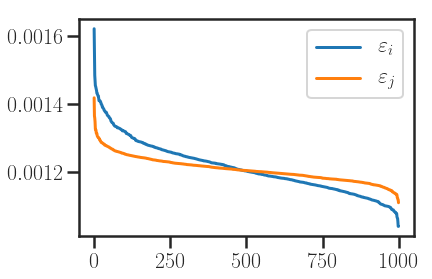

In [4]:
epsilons_a = np.sqrt(a / K.sum(axis=1))
epsilons_a_sort = np.sort(epsilons_a)[::-1]
epsilons_b = np.sqrt(b / K.T.sum(axis=1))
epsilons_b_sort = np.sort(epsilons_b)[::-1]
plt.plot(epsilons_a_sort, label=r'$\varepsilon_i$')
plt.plot(epsilons_b_sort, label=r'$\varepsilon_j$')
plt.legend();

#### Choice of epsilon

In [5]:
epsilons_ab = np.sort(np.hstack([epsilons_a, epsilons_b]))[::-1]
epsilon_mid = (max(epsilons_ab) - min(epsilons_ab))/2+ min(epsilons_ab)
epsilon_min = min(epsilons_ab)
epsilon_max = max(epsilons_ab)

epsilon_min, epsilon_mid, epsilon_max

(0.0010384082990002894, 0.0013295665182757328, 0.0016207247375511762)

In [6]:
# theoretical epsilon_min and epsilon_max
epsilon_min_th = max((np.sqrt(a/K.sum(axis=1))).min(), (np.sqrt(b/K.T.sum(axis=1))).min())
epsilon_max_th = min((np.sqrt(a/K.sum(axis=1))).max(), (np.sqrt(b/K.T.sum(axis=1))).max())

In [7]:
epsilon_min_th, epsilon_max_th

I_active = np.where(a >= epsilon_max_th**2 * K.sum(axis=1))[0].tolist()
J_active = np.where(b >= epsilon_max_th**2 * K.T.sum(axis=1))[0].tolist()

len(I_active), len(J_active)

(15, 1)

In [8]:
# theoretical epsilon_min and epsilon_max
(m, n) = K.shape
epsilon_max_th_bis = max( 
                np.sqrt(a.max() / ((K.sum(axis=1)).min())),  np.sqrt(b.max() / ((K.T.sum(axis=1)).min())))

epsilon_min_th_bis = min( 
    
                np.sqrt(a.min() / ((K.sum(axis=1)).min())),  np.sqrt(b.min() / ((K.T.sum(axis=1)).min())))

In [9]:
epsilon_min_th_bis, epsilon_max_th_bis

(0.001417272673847888, 0.0016207247375511762)

In [10]:
epsilon_max_u = a.max() / ((K.sum(axis=1)).max())
epsilon_max_v = b.max() / ((K.T.sum(axis=1)).max())

epsilon_max_uv = min(epsilon_max_u, epsilon_max_v)

epsilon_min_u = a.min() / ((K.sum(axis=1)).min())
epsilon_min_v = b.min() / ((K.T.sum(axis=1)).min())

epsilon_min_uv = max(epsilon_min_u, epsilon_min_v)

In [11]:
np.sqrt(epsilon_min_uv), epsilon_max_uv, epsilon_max_u, epsilon_max_uv

(0.0016207247375511762,
 1.0782917954326745e-06,
 1.0782917954326745e-06,
 1.0782917954326745e-06)

In [12]:
epsilon_max_uu = epsilon_max_u / epsilon_max_uv
epsilon_min_uu = epsilon_min_u / epsilon_max_uv


epsilon_max_uu, epsilon_min_uu

(1.0, 2.436027693094263)

In [13]:
epsilon_max_uv, epsilon_min_uv

(1.0782917954326745e-06, 2.626748674910329e-06)

In [14]:
epsilon_min_th, epsilon_max_th, 

(0.001108220582834891, 0.001417272673847888)

In [15]:
epsilon_mid_th = (epsilon_max_th - epsilon_min_th)/6 + epsilon_min_th
epsilon_mid_th

0.0011597292646703906

In [16]:
epsilon_mid_u = (epsilon_max_u - epsilon_min_u)/3 + epsilon_min_u
epsilon_mid_v = (epsilon_max_v - epsilon_min_v)/3 + epsilon_min_v

In [17]:
epsilon_mid_u, epsilon_mid_v

(2.1105963817511108e-06, 1.7484921747635967e-06)

#### Initial points and a priori active sets

In [18]:

u0 = np.full(n_1, epsilon_mid)
v0 = np.full(n_2, epsilon_mid)

I_active = np.where(a >= epsilon_max_th**2 * K.sum(axis=1))[0].tolist()
J_active = np.where(b >= epsilon_max_th**2 * K.T.sum(axis=1))[0].tolist()

u0[I_active] = epsilon_mid
v0[J_active] = epsilon_mid

In [19]:
## Cardinals of I_active and J_active

epsilon_max_th_th = min( 
                np.sqrt(a.max() / (K.sum(axis=1))),  np.sqrt(b.max() / (K.T.sum(axis=1))))

epsilon_min_th_th = max( 
                np.sqrt(a.min() / (K.sum(axis=1))),  np.sqrt(b.min() / (K.T.sum(axis=1))))

epsilon_max_th_th, epsilon_min_th_th 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [20]:
## Cardinals of I_active and J_active
epsilon_active = epsilon_max_th_th
I_active = np.where(a >= epsilon_active**2 * K.sum(axis=1))[0].tolist()
J_active = np.where(b >= epsilon_active**2 * K.T.sum(axis=1))[0].tolist()

len(I_active), len(J_active)

NameError: name 'epsilon_max_th_th' is not defined

In [21]:
## Initialize Screenkhorn class
I_active = list(range(n_1))
J_active = list(range(n_2))
epsilon = 1e-5

u0 = np.full(n_1,epsilon)
v0 = np.full(n_2, epsilon)

screenkhorn = Screenkhorn(a, b, M, reg, epsilon, I_active, J_active)

## L-BFGS-B

In [22]:
## Initialization outside LBFGS takes 30 x sinkhorn
# res_sink = screenkhorn.restricted_sinkhorn(u0, v0, I_active, J_active, max_iter=1000, tol=1e-9)

u0_I = u0[I_active]
v0_J = v0[J_active]
tic = time()
lbfgsb = screenkhorn.lbfgsb(u0_I, v0_J)
toc_bfgs = time() - tic
toc_bfgs

Certificate is achieved
Time spending during the restricted Skinkhorn is 0.010616064071655273


0.025691747665405273

In [23]:
time_sink, toc_bfgs, time_sink / toc_bfgs,  toc_bfgs / time_sink
# (0.5018818378448486, 2.3092141151428223, 4.601111140141898) 
# (0.5108699798583984, 1.788315773010254, 3.5005301613258513)

(0.029742956161499023,
 0.025691747665405273,
 1.1576852049480786,
 0.8637926750086171)

In [24]:
time_sink / 0.0019719600677490234

15.08294039414823

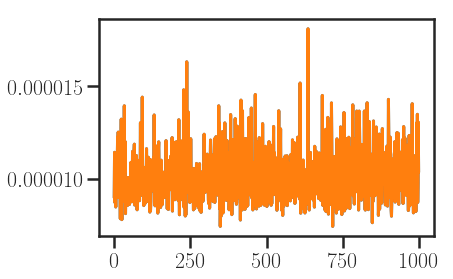

In [28]:
plt.plot(exp_u_star/1e2)
plt.plot(lbfgsb[0])

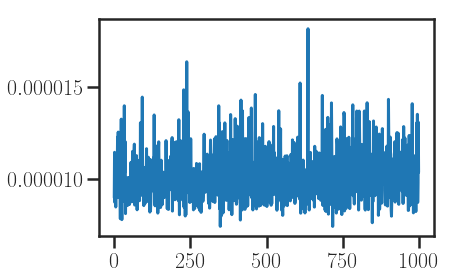

In [26]:
plt.plot(lbfgsb[0])

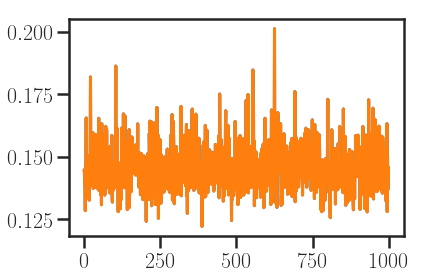

In [31]:
plt.plot(exp_v_star*1e2)
plt.plot(lbfgsb[1])

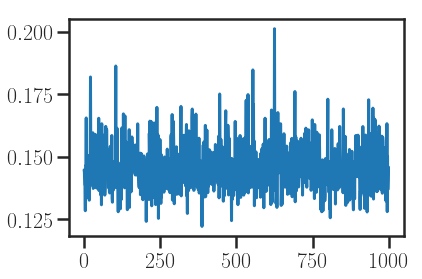

In [30]:
#plt.plot(exp_v_star)
plt.plot(lbfgsb[1])

In [32]:
# sinkhorn
P_star = np.diag(exp_u_star) @ K @ np.diag(exp_v_star)
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

# screenkhorn via lbfgsb
usc_bfgs = lbfgsb[0]
vsc_bfgs = lbfgsb[1]
P_sc_bfgs = np.diag(usc_bfgs) @ K @ np.diag(vsc_bfgs)
a_sc_bfgs = P_sc_bfgs @ np.ones(n_2)
b_sc_bfgs = P_sc_bfgs.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_bfgs), sum(b_sc_bfgs)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_bfgs)), abs(1 - sum(b_sc_bfgs))))
print("\t")
print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(P_star - P_sc_bfgs,'fro'))
print('\t')
print("Max norm of difference solution matrices %s "  %abs(P_star - P_sc_bfgs).max())

sum of the marginals in sinkhorn are: 1.0000000000000007, 	 1.0000000000000007
	
sum of the marginals in screenkhorn are: 0.9999990957012598, 	 0.9999990957012606
	
Difference in sinkhorn: 6.661338147750939e-16 	 6.661338147750939e-16:
	
Difference in screenkhorn: 9.042987402230196e-07 	  9.042987394458635e-07:
	
Frobenius norm of difference solution matrices 2.808158816149282e-08 
	
Max norm of difference solution matrices 1.8113172713995213e-10 


### Time for greenkhorn

In [ ]:
tic = time()
P = greenkhorn(a, b, M, reg, numItermax=100000, stopThr=1e-9, log=False)
P
time_green = time() - tic
time_green, time_sink, time_green/time_sink